In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import time

In [2]:
import subprocess
from collections import defaultdict

Note that it's not necessary to specify levels for "thermal" in GFS

In [3]:
hr = 0

levels = {}
for typeOfLevel in ["heightAboveGround", "heightAboveGroundLayer", "pressureFromGroundLayer", "isobaricInhPa"]:
    print(typeOfLevel)
    each_set_of_levels = []
    for fhr in [0, 6]:
        for suffix in ["", "b"]:
            output = subprocess.check_output([
                "grib_ls",
                "-p", "level,typeOfLevel",
                f"grib-store/gfs.0p25{suffix}.20220101{hr:02d}.f{fhr:03d}.grib2"
            ]).decode()
        
            each_set_of_levels.append(
                set(
                    int(line.split()[0]) for line in output.splitlines()
                    if typeOfLevel in line
                )
            )
    levels[typeOfLevel] = sorted(set().union(*each_set_of_levels))
    print(levels[typeOfLevel])
    print()

heightAboveGround
[2, 10, 20, 30, 40, 50, 80, 100, 1000, 3000, 4000, 6000]

heightAboveGroundLayer
[3000, 6000]

pressureFromGroundLayer
[3000, 6000, 9000, 12000, 15000, 18000, 25500]

isobaricInhPa
[1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 70, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]



In [7]:
keys = [
    'surface',
    'planetaryBoundaryLayer',
    'isobaricInhPa',
    'meanSea',
    'depthBelowLandLayer',
    'heightAboveGround',
    'atmosphereSingleLayer',
    'heightAboveGroundLayer',
    'tropopause',
    'maxWind',
    'heightAboveSea',
    'isothermZero',
    'highestTroposphericFreezing',
    'pressureFromGroundLayer',
    'sigmaLayer',
    'sigma',
    'potentialVorticity',
    # only in forecast
    'lowCloudLayer',
    'middleCloudLayer',
    'highCloudLayer',
    'atmosphere',
    'convectiveCloudBottom',
    'lowCloudBottom',
    'middleCloudBottom',
    'highCloudBottom',
    'convectiveCloudTop',
    'lowCloudTop',
    'middleCloudTop',
    'highCloudTop',
    'convectiveCloudLayer',
    'boundaryLayerCloudLayer',
    'nominalTop',
]

In [8]:
for k in sorted(keys):
    print(f'\t"{k}"')

	"atmosphere"
	"atmosphereSingleLayer"
	"boundaryLayerCloudLayer"
	"convectiveCloudBottom"
	"convectiveCloudLayer"
	"convectiveCloudTop"
	"depthBelowLandLayer"
	"heightAboveGround"
	"heightAboveGroundLayer"
	"heightAboveSea"
	"highCloudBottom"
	"highCloudLayer"
	"highCloudTop"
	"highestTroposphericFreezing"
	"isobaricInhPa"
	"isothermZero"
	"lowCloudBottom"
	"lowCloudLayer"
	"lowCloudTop"
	"maxWind"
	"meanSea"
	"middleCloudBottom"
	"middleCloudLayer"
	"middleCloudTop"
	"nominalTop"
	"planetaryBoundaryLayer"
	"potentialVorticity"
	"pressureFromGroundLayer"
	"sigma"
	"sigmaLayer"
	"surface"
	"tropopause"


In [13]:
def read_them(fbk, hr=0):
    """This one is geared toward comparing what's available in forecast vs analysis"""
    print(fbk)

    allvars = {}
    for fhr in [0, 6]:
        a = xr.open_dataset(
            f"grib-store/gfs.0p25.20220101{hr:02d}.f{fhr:03d}.grib2",
            engine="cfgrib",
            decode_timedelta=True,
            filter_by_keys=fbk,
        )
        
        b = xr.open_dataset(
            f"grib-store/gfs.0p25b.20220101{hr:02d}.f{fhr:03d}.grib2",
            engine="cfgrib",
            decode_timedelta=True,
            filter_by_keys=fbk,
        )
        xds = xr.merge([a,b])
        allvars[fhr] = set(list(a.data_vars)+list(b.data_vars))

    both = sorted(list( allvars[0].intersection(allvars[6]) ))
    both = {k: xds[k].attrs["long_name"] for k in both}
    only0 = sorted(list( allvars[0] - allvars[6] ))
    only0 = {k: xds[k].attrs["long_name"] for k in only0}
    only6 = sorted(list( allvars[6] - allvars[0] ))
    only6 = {k: xds[k].attrs["long_name"] for k in only6}
    print(f"\tBoth: {both}")
    print(f"\tAnalysis: {only0}")
    print(f"\tForecast: {only6}")
    return a, b

In [16]:
stepTypes = {
    "atmosphere": ["instant", "avg"],
    "surface": ["instant", "avg", "accum"],
}

In [17]:
for typeOfLevel in sorted(keys):
    fbk = {"typeOfLevel": typeOfLevel}
    if typeOfLevel in levels:

        for level in levels[typeOfLevel]:
            fbk["level"] = level
            a, b = read_them(fbk)
    elif typeOfLevel in stepTypes:
        for stepType in stepTypes[typeOfLevel]:
            fbk["stepType"] = stepType
            prs, sfc = read_them(fbk)
            
        
    else:
        a, b = read_them(fbk)


{'typeOfLevel': 'atmosphere', 'stepType': 'instant'}
	Both: {'refc': 'Maximum/Composite radar reflectivity', 'tcc': 'Total Cloud Cover'}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'atmosphere', 'stepType': 'avg'}
	Both: {}
	Analysis: {}
	Forecast: {'tcc': 'Total Cloud Cover'}
{'typeOfLevel': 'atmosphereSingleLayer'}
	Both: {'cwat': 'Cloud water', 'pwat': 'Precipitable water', 'r': 'Relative humidity', 'tozne': 'Total ozone'}
	Analysis: {}
	Forecast: {'cwork': 'Cloud work function'}
{'typeOfLevel': 'boundaryLayerCloudLayer'}
	Both: {}
	Analysis: {}
	Forecast: {'tcc': 'Total Cloud Cover'}
{'typeOfLevel': 'convectiveCloudBottom'}
	Both: {}
	Analysis: {}
	Forecast: {'pres': 'Pressure'}
{'typeOfLevel': 'convectiveCloudLayer'}
	Both: {}
	Analysis: {}
	Forecast: {'tcc': 'Total Cloud Cover'}
{'typeOfLevel': 'convectiveCloudTop'}
	Both: {}
	Analysis: {}
	Forecast: {'pres': 'Pressure'}
{'typeOfLevel': 'depthBelowLandLayer'}
	Both: {'soill': 'Liquid volumetric soil moisture (non-frozen)', 'soilw

skipping variable: paramId==130 shortName='t'
Traceback (most recent call last):
  File "/Users/tsmith/miniconda3/envs/ufs2arco/lib/python3.11/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/tsmith/miniconda3/envs/ufs2arco/lib/python3.11/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveSea' value=Variable(dimensions=(), data=np.float64(10.0)) new_value=Variable(dimensions=('heightAboveSea',), data=array([1829., 2743., 3658.]))
skipping variable: paramId==131 shortName='u'
Traceback (most recent call last):
  File "/Users/tsmith/miniconda3/envs/ufs2arco/lib/python3.11/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/tsmith/miniconda3/envs/ufs2arco/lib/python3.11/site-packages/cfgrib/dataset.py", line 641, in di

	Both: {'t': 'Temperature', 'u100': '100 metre U wind component', 'v100': '100 metre V wind component'}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveGround', 'level': 1000}
	Both: {'refd': 'Derived radar reflectivity'}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveGround', 'level': 3000}
	Both: {}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveGround', 'level': 4000}
	Both: {'refd': 'Derived radar reflectivity'}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveGround', 'level': 6000}
	Both: {}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveGroundLayer', 'level': 3000}
	Both: {'hlcy': 'Storm relative helicity'}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveGroundLayer', 'level': 6000}
	Both: {'ustm': 'U-component storm motion', 'vstm': 'V-component storm motion'}
	Analysis: {}
	Forecast: {}
{'typeOfLevel': 'heightAboveSea'}
	Both: {'t': 'Temperature', 'u': 'U component of wind', 'unknown': 'unknown', 'v': 'V component of wind'}
	An

In [8]:
ds = xr.open_dataset(
    "grib-store/hrrr.t00z.wrfprsf06.grib2",
    engine="cfgrib",
    filter_by_keys={
        "typeOfLevel": "meanSea",
        #"level": level,
        #"paramId": 131,
        #"stepType": stepType,
    },
    decode_timedelta=True,
)

In [15]:
ds.time.values

np.datetime64('2018-04-25T00:00:00.000000000')

## Here's what we got

In [25]:
typeOfLevels = [
    "atmosphere",
    "depthBelowLandLayer",
    "heightAboveGround",
    "highCloudLayer",
    "isobaricInhPa",
    "lowCloudLayer",
    "meanSea",
    "middleCloudLayer",
    "surface",
]

In [26]:
isobaric_variables = {
    "gh": 156,
	"t": 130,
	"r": 157,
	"w": 135,
	"u": 131,
	"v": 132,
	"absv": 3041,
	"clwmr": 260018,
	"ICSEV": 7001293,
	"o3mr": 260131,
	"q": 133,
    "wavh5": 260080,
}

In [39]:
def read_fhr(fhr, fbk):
    t0 = time.time()
    hr = 0
    dslist = []
    a = xr.open_dataset(
        f"grib-store/gfs.0p25.20180425{hr:02d}.f{fhr:03d}.grib2",
        engine="cfgrib",
        decode_timedelta=True,
        filter_by_keys=fbk,
    )
    if "unknown" in a:
        a = a.drop_vars("unknown")
    b = xr.open_dataset(
        f"grib-store/gfs.0p25b.20180425{hr:02d}.f{fhr:03d}.grib2",
        engine="cfgrib",
        decode_timedelta=True,
        filter_by_keys=fbk,
    )
    if "unknown" in b:
        b = b.drop_vars("unknown")
    xds = xr.merge([a,b])
    tf = time.time()
    print(f"{fbk} in {tf-t0:.1f} sec")

    # figure out variables
    avars = sorted(a.data_vars)
    bvars = sorted(b.data_vars)
    allvars = sorted(xds.data_vars)
    for key in allvars:
        file_suffixes = []
        if key in avars:
            file_suffixes.append("")
        if key in bvars:
            file_suffixes.append("b")
        xds[key].attrs["file_suffixes"] = file_suffixes
    return xds

In [54]:
%%time
hr = 0

fds = {}
for fhr in [0, 6]:
    vlist = []
    dslist = []
    for typeOfLevel in typeOfLevels:
        fbk = {"typeOfLevel": typeOfLevel}
        if typeOfLevel == "heightAboveGround":
            for level in levels[typeOfLevel]:
                fbk["level"] = level
                xds = read_fhr(fhr, fbk)
                if len(xds) > 0:
                    xds = xds.drop_vars("heightAboveGround")
                
                    for key in ["aptmp", "tmax", "tmin", "pres", "t", "q", "u", "v", "pt", "refd"]:
                        if key in xds:
                            new = f"{key}{level}"
                            xds = xds.rename({key: new})
                            xds[new].attrs["long_name"] = f"{level} metre " + xds[new].attrs["long_name"]
                            xds[new].attrs["original_name"] = key
                    for key in xds.data_vars:
                        xds[key].attrs["GRIB_level"] = level
                    dslist.append(xds) 
        elif typeOfLevel == "isobaricInhPa":
            for varname, paramId in isobaric_variables.items():
                fbk["paramId"] = paramId
                xds = read_fhr(fhr, fbk)
                if len(xds) > 0:
                    if len(xds.dims) < 3:
                        vv = xds["isobaricInhPa"].values
                        xds = xds.expand_dims({"isobaricInhPa": [vv]})
                    dslist.append(xds)
                
    
        elif typeOfLevel == "surface":
            xds = read_fhr(fhr, fbk)
            xds = xds.drop_vars(typeOfLevel)
            if len(xds) > 0:
                if "t" in xds:
                    xds = xds.rename({"t": "t_surface"})
                    xds["t_surface"].attrs["original_name"] = "t"
                    
                dslist.append(xds)
        else:
            xds = read_fhr(fhr, fbk)
            if len(xds) > 0:
                xds = xds.drop_vars(typeOfLevel)
                if len(xds) > 0:
                    if typeOfLevel in ("lowCloudLayer", "middleCloudLayer", "highCloudLayer"):
                        full = typeOfLevel.replace("CloudLayer", "") # l, m, or h
                        new = f"{full[0]}cc"
                        xds = xds.rename({"tcc": new})
                        for kk in ["long_name", "GRIB_name"]:
                            xds[new].attrs[kk] = xds[new].attrs[kk].replace("Total", full.capitalize())
                        for kk in ["GRIB_cfVarName", "GRIB_shortName"]:
                            xds[new].attrs[kk] = new
                        xds[new].attrs["original_name"] = "tcc"
                        
                    dslist.append(xds)
    fds[fhr] = xr.merge(dslist)

{'typeOfLevel': 'atmosphere'} in 0.0 sec
{'typeOfLevel': 'depthBelowLandLayer'} in 0.0 sec
{'typeOfLevel': 'heightAboveGround', 'level': 2} in 0.0 sec
	t2m
	sh2
	d2m
	r2
	aptmp2
{'typeOfLevel': 'heightAboveGround', 'level': 10} in 0.0 sec
	u10
	v10
{'typeOfLevel': 'heightAboveGround', 'level': 80} in 0.0 sec
	t80
	q80
	pres80
	u80
	v80
{'typeOfLevel': 'heightAboveGround', 'level': 100} in 0.0 sec
	t100
	u100
	v100
{'typeOfLevel': 'heightAboveGround', 'level': 3000} in 0.0 sec
{'typeOfLevel': 'heightAboveGround', 'level': 6000} in 0.0 sec
{'typeOfLevel': 'highCloudLayer'} in 0.0 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 156} in 2.3 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 130} in 2.1 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 157} in 2.0 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 135} in 1.5 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 131} in 2.1 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 132} in 2.3 sec
{'typeOfLevel': 'isobaricInhPa', 'paramId': 3041} i

In [55]:
fds[0].aptmp2

<xarray.DataArray 'aptmp2' (latitude: 721, longitude: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B 2018-04-25
    step        timedelta64[ns] 8B 00:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] 8B 2018-04-25
Attributes: (12/33)
    GRIB_paramId:                             260255
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    long_name:                                2 metre Apparent temperature
    units:                                    K
    standard_name:                            unknown
    file_suffixes:                            ['']
    original_name:                            aptmp
    GRIB_level:                               2

In [66]:
allvars = set(fds[0].data_vars).union(fds[6].data_vars)
both = set(fds[0].data_vars).intersection(fds[6].data_vars)
analysis = set(fds[0].data_vars) - set(fds[6].data_vars)
forecast = set(fds[6].data_vars) - set(fds[0].data_vars)

In [67]:
print(sorted(allvars))

['ICSEV', 'SUNSD', 'absv', 'acpcp', 'aptmp2', 'avg_al', 'avg_ishf', 'avg_slhtf', 'avg_utaua', 'avg_vtaua', 'cape', 'cduvb', 'cfrzr', 'cicep', 'cin', 'clwmr', 'cnwat', 'cpofp', 'cpr', 'crain', 'csnow', 'd2m', 'duvb', 'fldcp', 'gflux', 'gh', 'gust', 'hcc', 'hindex', 'iegwss', 'ingwss', 'landn', 'lcc', 'lftx', 'lftx4', 'lsm', 'mcc', 'mslet', 'o3mr', 'orog', 'prate', 'pres80', 'prmsl', 'q', 'q80', 'r', 'r2', 'sde', 'sdlwrf', 'sdswrf', 'sdwe', 'sh2', 'siconc', 'sithick', 'soill', 'soilw', 'sp', 'st', 'sulwrf', 'suswrf', 't', 't100', 't2m', 't80', 't_surface', 'tcc', 'tmax2', 'tmin2', 'tp', 'u', 'u10', 'u100', 'u80', 'v', 'v10', 'v100', 'v80', 'vis', 'w', 'watr', 'wavh5', 'wilt']


In [68]:
print(sorted(both))

['SUNSD', 'absv', 'aptmp2', 'cape', 'cin', 'clwmr', 'cnwat', 'cpofp', 'd2m', 'fldcp', 'gh', 'gust', 'hindex', 'landn', 'lftx', 'lftx4', 'lsm', 'mslet', 'o3mr', 'orog', 'pres80', 'prmsl', 'q', 'q80', 'r', 'r2', 'sde', 'sdwe', 'sh2', 'siconc', 'sithick', 'soill', 'soilw', 'sp', 'st', 't', 't100', 't2m', 't80', 't_surface', 'u', 'u10', 'u100', 'u80', 'v', 'v10', 'v100', 'v80', 'vis', 'w', 'wavh5', 'wilt']


In [69]:
print(sorted(analysis))

[]


In [70]:
print(sorted(forecast))

['ICSEV', 'acpcp', 'avg_al', 'avg_ishf', 'avg_slhtf', 'avg_utaua', 'avg_vtaua', 'cduvb', 'cfrzr', 'cicep', 'cpr', 'crain', 'csnow', 'duvb', 'gflux', 'hcc', 'iegwss', 'ingwss', 'lcc', 'mcc', 'prate', 'sdlwrf', 'sdswrf', 'sulwrf', 'suswrf', 'tcc', 'tmax2', 'tmin2', 'tp', 'watr']


### Make the reference yaml

In [71]:
ds = fds[6]

In [72]:
bigdict = {}
for varname in sorted(allvars):
    bigdict[varname] = {
        "filter_by_keys": {
            "typeOfLevel": ds[varname].GRIB_typeOfLevel,
            "paramId": ds[varname].GRIB_paramId,
        },
        "file_suffixes": ds[varname].file_suffixes,
        "long_name": ds[varname].long_name,
        "forecast_only": varname in forecast,
    }
    if ds[varname].GRIB_typeOfLevel == "heightAboveGround":
        bigdict[varname]["filter_by_keys"]["level"] = ds[varname].attrs["GRIB_level"]
    if "original_name" in ds[varname].attrs:
        bigdict[varname]["original_name"] = ds[varname].original_name
        

In [73]:
import yaml

In [74]:
with open("reference.gfs.yaml", "w") as f:
    yaml.dump(bigdict, f)

In [75]:
bigdict

{'ICSEV': {'filter_by_keys': {'typeOfLevel': 'isobaricInhPa',
   'paramId': 7001293},
  'file_suffixes': [''],
  'long_name': 'Icing severity',
  'forecast_only': True},
 'SUNSD': {'filter_by_keys': {'typeOfLevel': 'surface', 'paramId': 7001292},
  'file_suffixes': [''],
  'long_name': 'Sunshine Duration',
  'forecast_only': False},
 'absv': {'filter_by_keys': {'typeOfLevel': 'isobaricInhPa', 'paramId': 3041},
  'file_suffixes': ['', 'b'],
  'long_name': 'Absolute vorticity',
  'forecast_only': False},
 'acpcp': {'filter_by_keys': {'typeOfLevel': 'surface', 'paramId': 3063},
  'file_suffixes': [''],
  'long_name': 'Convective precipitation (water)',
  'forecast_only': True},
 'aptmp2': {'filter_by_keys': {'typeOfLevel': 'heightAboveGround',
   'paramId': 260255,
   'level': 2},
  'file_suffixes': [''],
  'long_name': '2 metre Apparent temperature',
  'forecast_only': False,
  'original_name': 'aptmp'},
 'avg_al': {'filter_by_keys': {'typeOfLevel': 'surface', 'paramId': 235263},
  'file

In [184]:
for key in sorted(ds.data_vars):
    print(f"{key}: {ds[key].long_name}")

SUNSD: Sunshine Duration
acpcp: Convective precipitation (water)
aptmp2: 2 metre Apparent temperature
avg_al: Time-mean forecast albedo
avg_ishf: Time-mean surface sensible heat flux
avg_slhtf: Time-mean surface latent heat flux
avg_utaua: Time-mean U-component of atmospheric surface momentum flux
avg_vtaua: Time-mean V-component of atmospheric surface momentum flux
cape: Convective available potential energy
cduvb: Clear sky UV-B downward solar flux
cfrzr: Categorical freezing rain
cicep: Categorical ice pellets
cin: Convective inhibition
cnwat: Plant canopy surface water
cpofp: Percent frozen precipitation
cpr: Convective precipitation rate
crain: Categorical rain
csnow: Categorical snow
d2m: 2 metre dewpoint temperature
duvb: UV-B downward solar flux
fldcp: Field Capacity
gflux: Ground heat flux
gh: Geopotential height
gust: Wind speed (gust)
hcc: High Cloud Cover
hindex: Haines Index
iegwss: Instantaneous eastward gravity wave surface stress
ingwss: Instantaneous northward gravity 

In [79]:
xr.testing.assert_equal(xr.merge([ds.q, xr.DataArray(name="q")]), ds.q)

AssertionError: 

In [186]:
(ds.landn-ds.lsm).plot()

In [193]:
ds.prmsl

<xarray.DataArray 'mslet' (latitude: 721, longitude: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B 2018-04-25
    step        timedelta64[ns] 8B 06:00:00
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] 8B 2018-04-25T06:00:00
Attributes: (12/30)
    GRIB_paramId:                             260317
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         meanSea
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                MSLP (Eta model reduction)
    GRIB_shortName:                           mslet
    GRIB_units:                               Pa
    long_name:                                MSLP (Eta model reduction)
    units:                                    Pa
    standard_name:                            unknown

In [177]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:        (latitude: 721, longitude: 1440, depthBelowLandLayer: 4,
                    isobaricInhPa: 47)
Coordinates:
    time           datetime64[ns] 8B 2018-04-25
    step           timedelta64[ns] 8B 06:00:00
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] 8B 2018-04-25T06:00:00
  * isobaricInhPa  (isobaricInhPa) float64 376B 1.0 2.0 3.0 ... 975.0 1e+03
Dimensions without coordinates: depthBelowLandLayer
Data variables: (12/76)
    tcc            (latitude, longitude) float32 4MB ...
    st             (depthBelowLandLayer, latitude, longitude) float32 17MB ...
    soilw          (depthBelowLandLayer, latitude, longitude) float32 17MB ...
    soill          (depthBelowLandLayer, latitude, longitude) float32 17MB ...
    t2m            (latitude, longitude) float32 4MB ...
    sh2            (latitude, longitude) float32 4MB ...
    ...             ...
    avg_al         (latitude, longitude) float32 4MB ...
    landn          (latitude, longitude) float32 4MB ...
    cnwat          (latitude, longitude) float32 4MB ...
    sithick        (latitude, longitude) float32 4MB ...
    duvb           (latitude, longitude) float32 4MB ...
    cduvb          (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-05-29T11:17 GRIB to CDM+CF via cfgrib-0.9.1...

In [180]:
fig, axs = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True)
for key, ax in zip(["tcc", "hcc", "mcc", "lcc"], axs.flatten()):
    ds[key].plot(ax=ax)

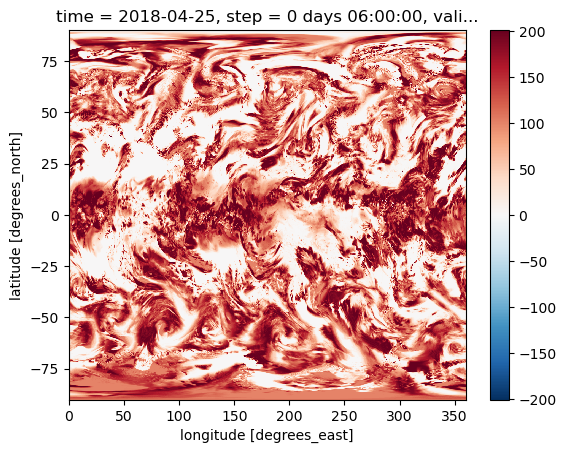

In [181]:
(ds.tcc*3 - (ds["lcc"] + ds["mcc"] + ds["hcc"])).plot()